### Animation of predictions

In [ ]:
# Imports

# Misc
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture

# Visualiation tools
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML, Image

# Pyro/PyTorch
import torch
from torch import nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, TraceEnum_ELBO, Predictive, NUTS, MCMC, config_enumerate
from pyro.infer.autoguide import AutoDelta, AutoDiagonalNormal, AutoMultivariateNormal
from pyro.optim import Adam, ClippedAdam
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from pyro.distributions import MultivariateNormal as MN
from pyro.ops.indexing import Vindex

# Implemented modules
from util import RFNDataset
from model import RMDN

In [ ]:
# Load data files

X_train_tensor, X_val_tensor, X_test_tensor =   torch.load("./data/X_train_tensor.pt"), \
                                                torch.load("./data/X_val_tensor.pt"),   \
                                                torch.load("./data/X_test_tensor.pt")
U_train_tensor, U_val_tensor, U_test_tensor =   torch.load("./data/U_train_tensor.pt"), \
                                                torch.load("./data/U_val_tensor.pt"),   \
                                                torch.load("./data/U_test_tensor.pt")
N_t_train, N_t_valid, N_t_test = np.load("./data/N_t_train.npy"), \
                                 np.load("./data/N_t_val.npy"),   \
                                 np.load("./data/N_t_test.npy")

# Concatenation
X_train_val = torch.cat((X_train_tensor, X_val_tensor), 1)
U_train_val = torch.cat((U_train_tensor, U_val_tensor), 1)

In [ ]:
# Instantiate and load model
grid = U_train_tensor.size(3)
model = RMDN(input_dim=grid, hidden_dim=128, LSTM_input=128, output_dim=2, K = 10)
model.load_state_dict(torch.load(''))
model.eval()

### Visualisation of training, validation and testing performance

In [92]:
# Define data boundaries
(lonMin, lonMax, latMin, latMax) = (12.52, 12.67, 55.62, 55.73)

# Define normalisation values
latmean = 55.67777941810432
latstd  = 0.022970362839316014
lonmean = 12.572154878154388
lonstd  = 0.03018063809393041

# Outer boundaries
lonmin = (lonMin-lonmean)/lonstd
latmin = (latMin-latmean)/latstd
lonmax = (lonMax-lonmean)/lonstd
latmax = (latMax-latmean)/latstd

# Define grid
n = 25
grid = np.zeros((n, n))
latvals = torch.linspace(latmin, latmax, n)
lonvals = torch.linspace(lonmin, lonmax, n)
xx, yy = torch.meshgrid(lonvals, latvals)

# Define sequence lengths
num_seq_train = U_train_tensor.size(1)
num_seq_val   = U_val_tensor.size(1)
num_seq_test  = U_test_tensor.size(1)

In [93]:
# Train visualisation
grid_tensor = torch.zeros((1, num_seq_train, n*n, 2))
grid_tensor[0, :, :, :] = torch.cat((xx.reshape(-1,1), yy.reshape(-1,1)),1)
grid_mask = (np.ones(num_seq_train)*n*n).astype(int)

# Expand tensors
#X_init = torch.zeros(1, X_train_tensor.size(1), n*n, 2)
#X_init[:, :, :X_train_tensor.size(2), :] = X_train_tensor[:, :, :, :]

# Compute likelihood for each data point
LL_train = model.get_loglikelihood(X=grid_tensor, U=U_train_tensor, mask=grid_mask, 
                                        X_init=None, U_init=None, mask_init=None)
LL_train = LL_train.reshape(-1, num_seq_train, n, n)

In [94]:
# Validation visualisation
grid_tensor = torch.zeros((1, num_seq_val, n*n, 2))
grid_tensor[0, :, :, :] = torch.cat((xx.reshape(-1,1), yy.reshape(-1,1)),1)
grid_mask = (np.ones(num_seq_val)*n*n).astype(int)

# Expand tensors
X_init = torch.zeros(1, X_train_tensor.size(1), n*n, 2)
X_init[:, :, :X_train_tensor.size(2), :] = X_train_tensor[:, :, :, :]

# Compute likelihood for each data point
LL_val = model.get_loglikelihood(X=grid_tensor, U=U_val_tensor, mask=grid_mask, 
                                        X_init=X_init, U_init=U_train_tensor, mask_init=N_t_train)
LL_val = LL_val.reshape(-1, num_seq_val, n, n)

In [95]:
# Test visualisation
grid_tensor = torch.zeros((1, num_seq_test, n*n, 2))
grid_tensor[0, :, :, :] = torch.cat((xx.reshape(-1,1), yy.reshape(-1,1)),1)
grid_mask = (np.ones(num_seq_test)*n*n).astype(int)

# Expand tensors
X_init = torch.zeros(1, X_train_tensor.size(1)+X_val_tensor.size(1), n*n, 2)
X_init[:, :X_train_tensor.size(1), :X_train_tensor.size(2), :] = X_train_tensor[:, :, :, :]
X_init[:, X_train_tensor.size(1):, X_train_tensor.size(2):(X_val_tensor.size(2)+X_train_tensor.size(2)), :] = X_val_tensor[:, :, :, :]
mask_init = np.hstack((N_t_train, N_t_valid))
U_init = torch.cat((U_train_tensor, U_val_tensor), 1)

# Compute likelihood for each data point
LL_test = model.get_loglikelihood(X=grid_tensor, U=U_test_tensor, mask=grid_mask, 
                                        X_init=X_init, U_init=U_init, mask_init=mask_init)
LL_test = LL_test.reshape(-1, num_seq_test, n, n)

In [153]:
def visualise_density(LL, X, mask, t=0):
    (lonMin, lonMax, latMin, latMax) = (12.52, 12.67, 55.62, 55.73)
    extent=(lonMin, lonMax, latMin, latMax)
    latmean = 55.67777941810432
    latstd  = 0.022970362839316014
    lonmean = 12.572154878154388
    lonstd  = 0.03018063809393041
    
    # Unpack X_tensor
    lon = X[:, t, :mask[t], 0].squeeze().numpy()*lonstd+lonmean
    lat = X[:, t, :mask[t], 1].squeeze().numpy()*latstd+latmean
    
    # Exctract data 
    image = np.rot90(LL[0, t, :, :].squeeze().numpy()).copy()
        
    fig = plt.figure(figsize=(10,10))
    plt.imshow(image, interpolation='bicubic',cmap='seismic', aspect='auto', extent=extent
              ,vmin=-6, vmax=np.max(image))
    plt.scatter(x=lon,y=lat, color='r', s=20)
    #plt.scatter(x=loc_np[:,0], y=loc_np[:,1], color='r', marker='x')
    plt.xlim([lonMin, lonMax])
    plt.ylim([latMin, latMax])
    plt.show()

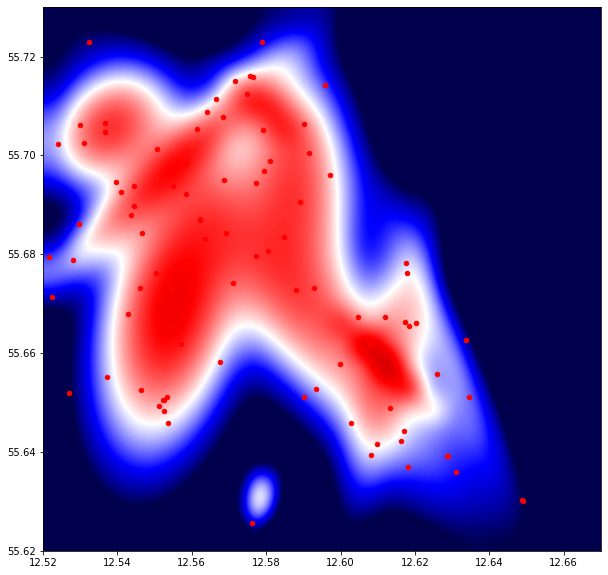

In [154]:
visualise_density(LL_train, X=X_train_tensor, mask=N_t_train, t=3)

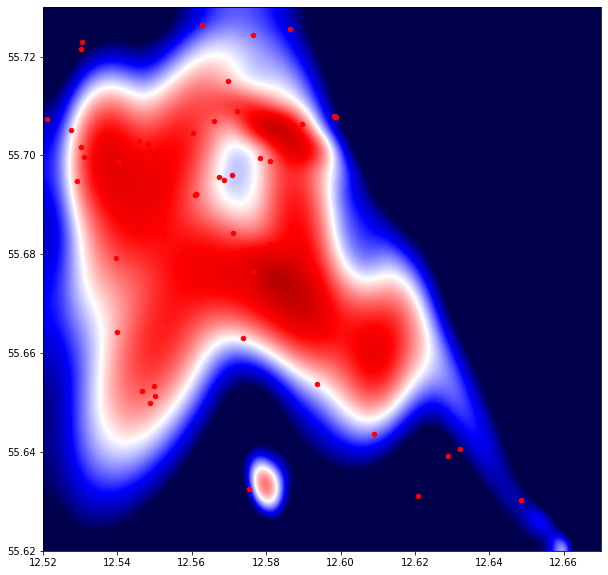

In [160]:
visualise_density(LL_val, X=X_val_tensor, mask=N_t_valid, t=1)

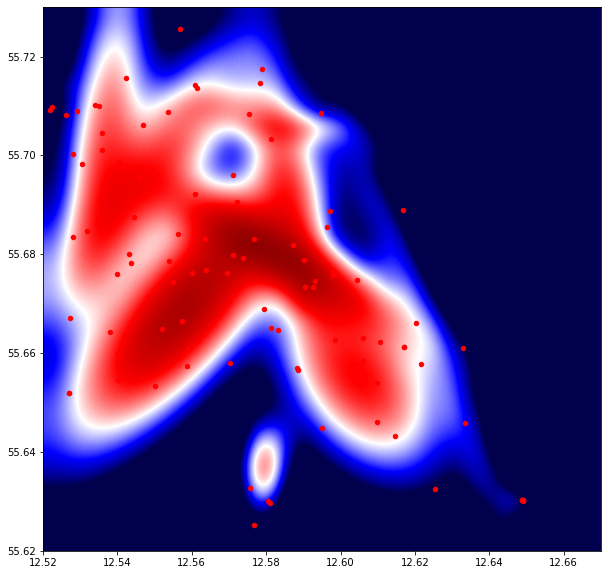

In [158]:
visualise_density(LL_test, X=X_test_tensor, mask=N_t_test, t=1)

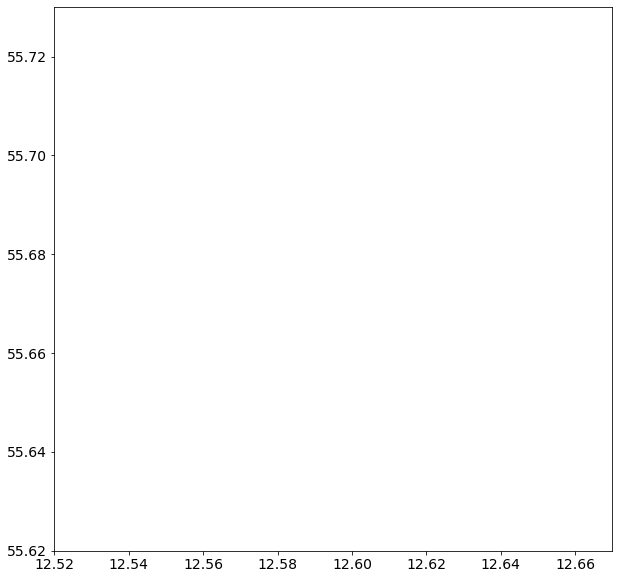

In [210]:
# ANIMATION

(lonMin, lonMax, latMin, latMax) = (12.52, 12.67, 55.62, 55.73)
extent=(lonMin, lonMax, latMin, latMax)
latmean = 55.67777941810432
latstd  = 0.022970362839316014
lonmean = 12.572154878154388
lonstd  = 0.03018063809393041
LL = LL_train
X = X_train_tensor
mask = N_t_train
t = 0
fig, ax = plt.subplots(figsize=(10,10));
ax.set_xlim([lonMin, lonMax])
ax.set_ylim([latMin, latMax])
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

#plt.title(f't = {t}')
#visualise_density(LL_train, X=X_train_tensor, mask=N_t_train, t=?)
def animate(t):
    ax.clear()
    ax.set_title(f"Training predictions (t = {t})")
    # Unpack X_tensor
    lon = X[:, t, :mask[t], 0].squeeze().numpy()*lonstd+lonmean
    lat = X[:, t, :mask[t], 1].squeeze().numpy()*latstd+latmean
    # Exctract data 
    image = np.rot90(LL[0, t, :, :].squeeze().numpy()).copy()
        
    #fig = plt.figure(figsize=(10,10))
    ax.imshow(image, interpolation='bicubic',cmap='seismic', aspect='auto', extent=extent
              ,vmin=-6, vmax=np.max(image))
    ax.scatter(x=lon,y=lat, color='r', s=20)
    
    return ax

In [211]:
anim = animation.FuncAnimation(fig, animate, frames=X_train_tensor.size(1), interval=20, blit=False, repeat=False)
anim.save('train_animated.gif', writer='imagemagick', fps=1)

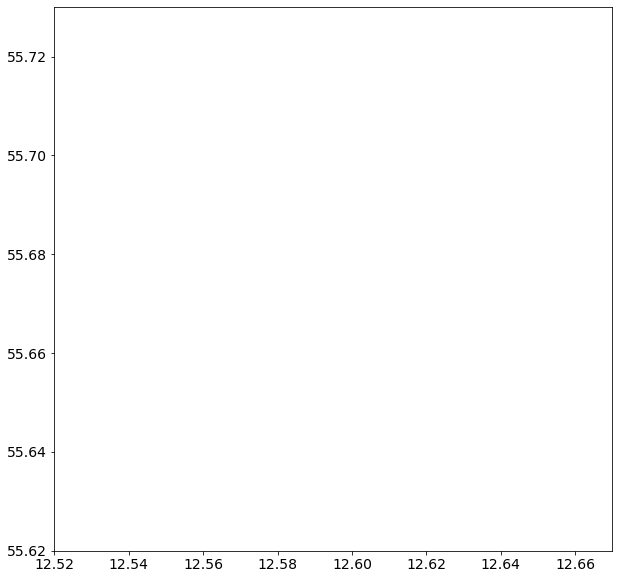

In [212]:
# ANIMATION

(lonMin, lonMax, latMin, latMax) = (12.52, 12.67, 55.62, 55.73)
extent=(lonMin, lonMax, latMin, latMax)
latmean = 55.67777941810432
latstd  = 0.022970362839316014
lonmean = 12.572154878154388
lonstd  = 0.03018063809393041
LL = LL_val
X = X_val_tensor
mask = N_t_valid
t = 0
fig, ax = plt.subplots(figsize=(10,10));
ax.set_xlim([lonMin, lonMax])
ax.set_ylim([latMin, latMax])
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

def animate_val(t):
    ax.clear()
    ax.set_title(f"Validation predictions (t = {t})")
    # Unpack X_tensor
    lon = X[:, t, :mask[t], 0].squeeze().numpy()*lonstd+lonmean
    lat = X[:, t, :mask[t], 1].squeeze().numpy()*latstd+latmean
    # Exctract data 
    image = np.rot90(LL[0, t, :, :].squeeze().numpy()).copy()
        
    #fig = plt.figure(figsize=(10,10))
    ax.imshow(image, interpolation='bicubic',cmap='seismic', aspect='auto', extent=extent
              ,vmin=-6, vmax=np.max(image))
    ax.scatter(x=lon,y=lat, color='r', s=20)
    
    return ax

In [213]:
anim = animation.FuncAnimation(fig, animate_val, frames=X_val_tensor.size(1), interval=20, blit=False, repeat=False)
anim.save('validation_animated.gif', writer='imagemagick', fps=1)

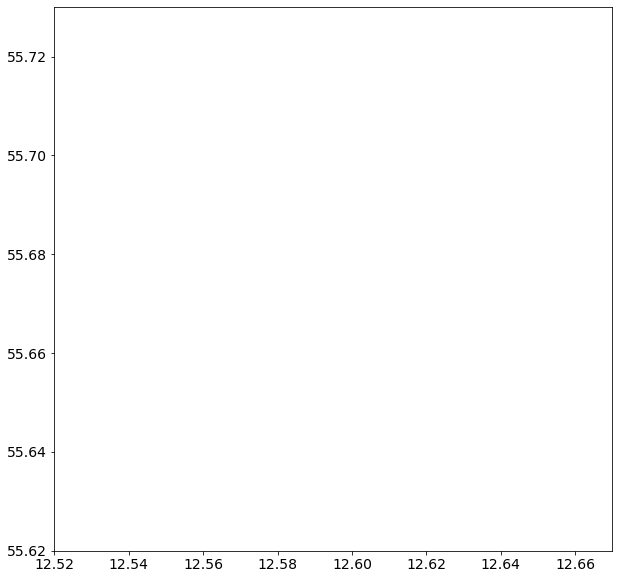

In [216]:
# ANIMATION

(lonMin, lonMax, latMin, latMax) = (12.52, 12.67, 55.62, 55.73)
extent=(lonMin, lonMax, latMin, latMax)
latmean = 55.67777941810432
latstd  = 0.022970362839316014
lonmean = 12.572154878154388
lonstd  = 0.03018063809393041
LL = LL_test
X = X_test_tensor
mask = N_t_test
t = 0
fig, ax = plt.subplots(figsize=(10,10));
ax.set_xlim([lonMin, lonMax])
ax.set_ylim([latMin, latMax])
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

def animate_test(t):
    ax.clear()
    ax.set_title(f"Test predictions (t = {t})")
    # Unpack X_tensor
    lon = X[:, t, :mask[t], 0].squeeze().numpy()*lonstd+lonmean
    lat = X[:, t, :mask[t], 1].squeeze().numpy()*latstd+latmean
    # Exctract data 
    image = np.rot90(LL[0, t, :, :].squeeze().numpy()).copy()
        
    #fig = plt.figure(figsize=(10,10))
    ax.imshow(image, interpolation='bicubic',cmap='seismic', aspect='auto', extent=extent
              ,vmin=-6, vmax=np.max(image))
    ax.scatter(x=lon,y=lat, color='r', s=20)
    
    return ax

In [217]:
anim = animation.FuncAnimation(fig, animate_test, frames=X_test_tensor.size(1), interval=20, blit=False, repeat=False)
anim.save('test_animated.gif', writer='imagemagick', fps=1)